## For each bee id, be able to provide the number of detections in the hive in the given timeslot.

In [236]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import math
import seaborn as sns
import numpy as np
import pandas as pd
import psycopg2
import psycopg2.extras
from datetime import timedelta, datetime
import time

import bb_utils
import bb_utils.meta
import bb_utils.ids
import bb_backend
from bb_backend.api import FramePlotter, VideoPlotter
from bb_backend.api import get_plot_coordinates, transform_axis_coordinates, get_image_origin

bb_backend.api.server_adress = 'localhost:8000'
connect_str = """dbname='beesbook' user='reader' host='tonic.imp.fu-berlin.de' 
                 password='' application_name='mehmed'"""

meta = bb_utils.meta.BeeMetaInfo()

In [237]:
#Parameters for loading data, currently using known date of 23th, august 2016)
num_hours = 24
datetime_start = datetime(2016, 8, 23)

#Parameters for presenting data
bin_size_in_hours = 24

#Hyperparameters for the data wrangling process
num_intervals_per_hour = 120
rolling_window_size = 11

print(datetime_start)
#(First detections are on 20.07.2016, last are 19.09.2016 (3 months duration))

2016-08-23 00:00:00


In [238]:
#Define bee IDs by getting a known forager group
meta = bb_utils.meta.BeeMetaInfo()

group_id = 20

bee_ids_as_beesbookid_format = list(map(bb_utils.ids.BeesbookID.from_dec_12, meta.get_foragergroup(group_id).dec12))
bee_ids_from_group = map(lambda i: i.as_ferwar(), bee_ids_as_beesbookid_format) #as ferwar

bee_ids_from_group = list(bee_ids_from_group)
# group = meta.get_foragergroup(group_id)
# print(group.date)

32

In [ ]:
#Calculate the ages for each bee of the forager group
bee_days_since_birth = [] 

for id in bee_ids_as_beesbookid_format:
    bee_days_since_birth.append((datetime_start - meta.get_hatchdate(id)).days)
    
#bee_days_since_birth[0]

### Reading from saved CSV files

In [239]:
#for testing: a single csv with hardcoded name
#sample_df = pd.read_csv('2016-08-23_00:00:00.csv', parse_dates=['timestamp'])

location_prefix = "/mnt/storage/janek/" # or ""

#Loading first element before the loop, to have a table formatted nicely for appending
start_csv_name = (datetime_start).strftime("%Y-%m-%d_%H:%M:%S")+".csv"

print('Processing '+location_prefix+start_csv_name+' before the loop')
detections_df = pd.read_csv(location_prefix+start_csv_name, parse_dates=['timestamp'], usecols=['timestamp', 'bee_id'])

detections_df.head()

Processing /mnt/storage/janek/2016-08-23_00:00:00.csv before the loop


,timestamp,bee_id
0,2016-08-23 00:27:31.780472,3073
1,2016-08-23 00:27:32.116578,3073
2,2016-08-23 00:27:32.447851,3073
3,2016-08-23 00:27:32.783652,3073
4,2016-08-23 00:27:33.109483,3073


In [240]:
#read and concat a number of hour-long csvs (note: thekla memory crashes if >16)
for i in range(1, num_hours):
    csv_name = (datetime_start + timedelta(hours=i)).strftime("%Y-%m-%d_%H:%M:%S")+".csv"
    print('Processing '+csv_name)
    new_data = pd.read_csv(location_prefix+csv_name, parse_dates=['timestamp'], usecols=['timestamp', 'bee_id'])
    detections_df = pd.concat([detections_df, new_data])
    print('Num. rows after appending: '+str(detections_df.shape[0]))

Processing 2016-08-23_01:00:00.csv
Num. rows after appending: 6795262
Processing 2016-08-23_02:00:00.csv
Num. rows after appending: 10195578
Processing 2016-08-23_03:00:00.csv
Num. rows after appending: 13643441
Processing 2016-08-23_04:00:00.csv
Num. rows after appending: 17171049
Processing 2016-08-23_05:00:00.csv
Num. rows after appending: 20520678
Processing 2016-08-23_06:00:00.csv
Num. rows after appending: 22617753
Processing 2016-08-23_07:00:00.csv
Num. rows after appending: 25885315
Processing 2016-08-23_08:00:00.csv
Num. rows after appending: 29422176
Processing 2016-08-23_09:00:00.csv
Num. rows after appending: 32896095
Processing 2016-08-23_10:00:00.csv
Num. rows after appending: 36475063
Processing 2016-08-23_11:00:00.csv
Num. rows after appending: 40180078
Processing 2016-08-23_12:00:00.csv
Num. rows after appending: 43288399
Processing 2016-08-23_13:00:00.csv
Num. rows after appending: 46654242
Processing 2016-08-23_14:00:00.csv
Num. rows after appending: 50162001
Process

In [241]:
#interval length is the total observation period divided by total number of intervals
total_num_intervals = (num_intervals_per_hour*num_hours)
interval_length = timedelta(hours=num_hours) // (num_intervals_per_hour*num_hours)

# prepare dataframe with zeros in the shape [bees x total_num_intervals]
# append bee_ids from the left
intervals = pd.DataFrame(data=np.zeros([len(bee_ids_from_group),total_num_intervals])) 
bee_ids = pd.DataFrame(data={'id': bee_ids_from_group})
presence_df = pd.concat([bee_ids, intervals], axis=1)

In [ ]:
#Iterate over intervals and over detections
#If a bee from bee_ids is detected within a given interval, mark the cell for that bee and interval with a '1'

interval_starttime = datetime_start
# print("Processing intervals: ")
for interval in range(total_num_intervals): 
    #choose detections for interval
    interval_endtime = interval_starttime + interval_length
    before = detections_df['timestamp'] >= interval_starttime 
    after = detections_df['timestamp'] < interval_endtime
    interval_detections = detections_df[before & after]
    bee_row_number = 0
    for bee in presence_df['id']: 
        if bee in interval_detections['bee_id'].unique():
            presence_df.set_value(bee_row_number, interval, 1)
        bee_row_number += 1 
    interval_starttime = interval_endtime
    if interval%100 == 0:
        print(interval,", ", end='')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 

In [155]:
date_string = (datetime_start).strftime("%Y-%m-%d_%H")
csv_name = 'PRESENCE-'+str(date_string)+"_num_hours_"+str(num_hours)+"_int_size_"+str(num_intervals_per_hour)+'.csv'

In [199]:
# (presence_df == 1).astype(int).sum(axis=1)
(presence_temp == 1).astype(int).sum(axis=1)
presence_df = presence_temp
# (presence_temp2 == 1).astype(int).sum(axis=1)

In [200]:
#Saving intermediate result: the presence dataframe, with 1's and 0's for bees present
presence_df.to_csv(location_prefix+csv_name)

In [201]:
presence_df.shape

(11, 2901)

In [202]:
#Loading the intermediate result (saved from prevoius cell)
print('Loading '+csv_name)
presence_df = pd.read_csv(location_prefix+csv_name)
print('Num. rows after appending: '+str(presence_df.shape))
#Note that this adds an unwanted column in pres_df that causes trouble later - remove it here
#presence_df

Loading PRESENCE-2016-08-23_00_num_hours_24_int_size_120.csv
Num. rows after appending: (11, 2902)


### Computing presence table

In [210]:
#Get lengths of bee trip intervals 
presence_temp2 = presence_df.iloc[:, 1:]
presence_temp2

,id,id.1,id.2,id.3,id.4,id.5,id.1.1,id.2.1,id.3.1,id.4.1,...,2879.1,2879.2,2879.3,2879.4,2879.5,2879.5.1,2879.5.2,2879.5.3,2879.5.4,2879.5.5
0,1799,1799,1799,1799,1799,1799,1799,1799,1799,1799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1593,1593,1593,1593,1593,1593,1593,1593,1593,1593,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2106,2106,2106,2106,2106,2106,2106,2106,2106,2106,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1662,1662,1662,1662,1662,1662,1662,1662,1662,1662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1180,1180,1180,1180,1180,1180,1180,1180,1180,1180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,1197,1197,1197,1197,1197,1197,1197,1197,1197,1197,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1714,1714,1714,1714,1714,1714,1714,1714,1714,1714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1471,1471,1471,1471,1471,1471,1471,1471,1471,1471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [219]:
# presence_temp2=presence_temp2.iloc[:, :-1]
presence_temp2

,id.5.1,0,1,2,3,4,5,6,7,8,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
0,1799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2106,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3,1662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
6,1197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1471,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
9,1232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
# presence_temp2.get_value(1799, 10)
# pd.concat([presence_df[]
# presence_temp2.iat[0, 10]

presence_temp2.iloc[:,1]

0     0.0
1     0.0
2     1.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     1.0
9     0.0
10    1.0
Name: 0, dtype: float64

In [221]:
trip_lengths = []

for bee in range(0, presence_temp2.shape[0]):
    curr_trip_length = 0
    curr_bee_trip_lenghts = []
    #fill with trip lengths
    for interval in range(total_num_intervals): #t: 2880
        #get the 0/1 value from presence_df at the given (bee, interval)
        bool_is_present = presence_temp2.iat[bee, interval]
        if bool_is_present == 0.0: #bee not present in this interval
            if curr_trip_length != 0: #if we had a value for a trip length -> means trip ends here -> add it to trips and reset the counter
                curr_bee_trip_lenghts.append(curr_trip_length)
                curr_trip_length = 0
        if bool_is_present == 1.0: #bee present in this interval, means trip is underway -> increment the length counter 
            curr_trip_length += 1
    trip_lengths.append(curr_bee_trip_lenghts)


In [222]:
pd.DataFrame(trip_lengths)

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,1,1,186,9,19,34,13,16,7,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,30,63,3,5,4,1,2,2,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16,21,17,41,21,14,41,61,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,42,5,1,8,4,2,8,6,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41,5,1,1,3,3,16,28,17,5,...,7.0,1.0,16.0,31.0,2.0,NaN,NaN,NaN,NaN,NaN
5,21,14,2,1,29,15,122,60,8,41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,21,11,5,3,24,14,14,28,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,30,8,1,19,15,7,2,5,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,26,12,3,5,11,2,9,18,5,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,41,1,2,16,11,6,5,2,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0        1
1        1
2      186
3        9
4       19
5       34
6       13
7       16
8        7
9       19
10       3
11       8
12       9
13       2
14      29
15       8
16      51
17       2
18       7
19      35
20      37
21      95
22      34
23      32
24      13
25       4
26       7
27      43
28       2
29       5
      ... 
845      3
846      2
847      4
848      3
849      4
850      8
851     27
852    161
853      6
854      2
855      4
856      6
857      8
858     35
859      9
860     44
861     12
862     11
863      2
864     15
865      8
866    121
867      5
868      4
869     10
870      7
871     18
872      5
873      2
874      7
Length: 875, dtype: int64

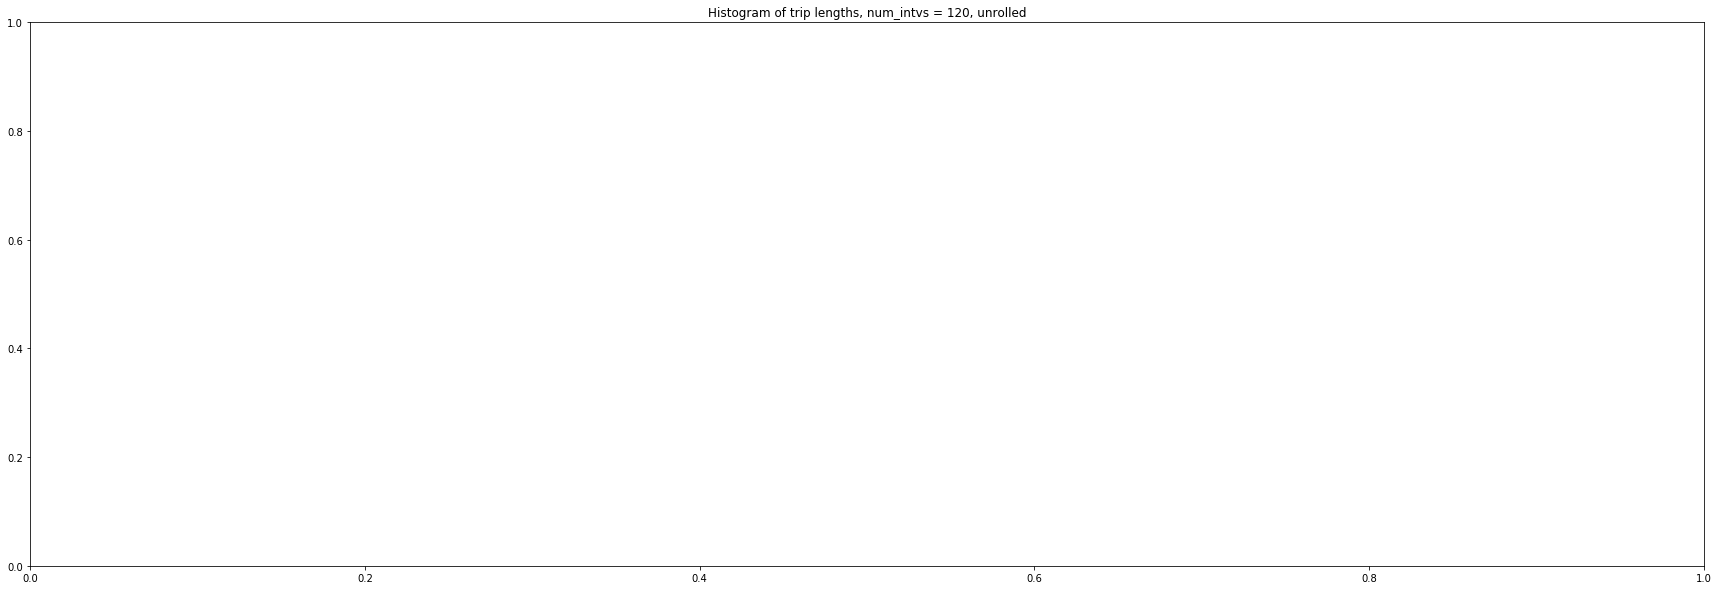

In [223]:
# np.save('trip_lenghts_23_08.npy', trip_lengths)    # .npy extension is added if not given
# test = np.load('trip_lenghts_23_08.npy')

trip_lengths


flat_list = [item for sublist in trip_lengths for item in sublist]
flat_series = pd.Series(flat_list)


plt.figure(figsize=(30,10))


flat_series_filtered = flat_series[flat_series<20]
# flat_series.hist(bins=680)
plt.title('Histogram of trip lengths, num_intvs = '+str(num_intervals_per_hour)+', unrolled')
flat_series

In [224]:
#Preparing for rolling median
num_nans_to_clean = math.floor(rolling_window_size/2)

#apply copies of the first and last column as offset for the rolling window
first_col = presence_df.iloc[:, 1:2]
last_col = presence_df.iloc[:, -1:]

presence_temp = presence_df.iloc[:, 1:]

presence = presence_df.iloc[:, 1:]
for i in range(0,num_nans_to_clean):
    presence_temp = pd.concat([first_col, presence_temp, last_col] ,axis=1)
    
presence_df

,Unnamed: 0,id,id.1,id.2,id.3,id.4,id.5,id.1.1,id.2.1,id.3.1,...,2879.1,2879.2,2879.3,2879.4,2879.5,2879.5.1,2879.5.2,2879.5.3,2879.5.4,2879.5.5
0,0,1799,1799,1799,1799,1799,1799,1799,1799,1799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1593,1593,1593,1593,1593,1593,1593,1593,1593,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,2106,2106,2106,2106,2106,2106,2106,2106,2106,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3,1662,1662,1662,1662,1662,1662,1662,1662,1662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1180,1180,1180,1180,1180,1180,1180,1180,1180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,2984,2984,2984,2984,2984,2984,2984,2984,2984,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,6,1197,1197,1197,1197,1197,1197,1197,1197,1197,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,7,1714,1714,1714,1714,1714,1714,1714,1714,1714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,1471,1471,1471,1471,1471,1471,1471,1471,1471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,1232,1232,1232,1232,1232,1232,1232,1232,1232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
# Applying rolling median window, to filter out noise in the dataframe
rolled = presence_temp.rolling(window=rolling_window_size,center=True,axis=1).median()

#clean up to get rid of the NaNs
rolled = rolled.iloc[:, num_nans_to_clean:-num_nans_to_clean]

In [226]:
#trip lengths again
rolled_trip_lenghs = []

for bee in range(0, rolled.shape[0]):
    curr_trip_length = 0
    curr_bee_trip_lenghts = []
    #fill with trip lengths
    for interval in range(total_num_intervals):
        
        #get the 0/1 value from presence_df at the given (bee, interval)
        bool_is_present = rolled.iat[bee, interval]

        if bool_is_present == 0.0: #bee not present in this interval
            if curr_trip_length != 0: #if we had a value for a trip length, add it to trips and reset the counter
                curr_bee_trip_lenghts.append(curr_trip_length)
                curr_trip_length = 0
        if bool_is_present == 1.0: #bee present in this interval, make the trip longer
            curr_trip_length += 1
    rolled_trip_lenghs.append(curr_bee_trip_lenghts)

 
rolled.head()

,id,id.1,id.2,id.3,id.4,id.5,id.1.1,id.2.1,id.3.1,id.4.1,...,2879.1,2879.2,2879.3,2879.4,2879.5,2879.5.1,2879.5.2,2879.5.3,2879.5.4,2879.5.5
0,1799.0,1799.0,1799.0,1799.0,1799.0,1799.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1593.0,1593.0,1593.0,1593.0,1593.0,1593.0,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2106.0,2106.0,2106.0,2106.0,2106.0,2106.0,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1662.0,1662.0,1662.0,1662.0,1662.0,1662.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1180.0,1180.0,1180.0,1180.0,1180.0,1180.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5,1,'Histogram of trip lengths, num_intvs = 120, roll_winsize = 11')

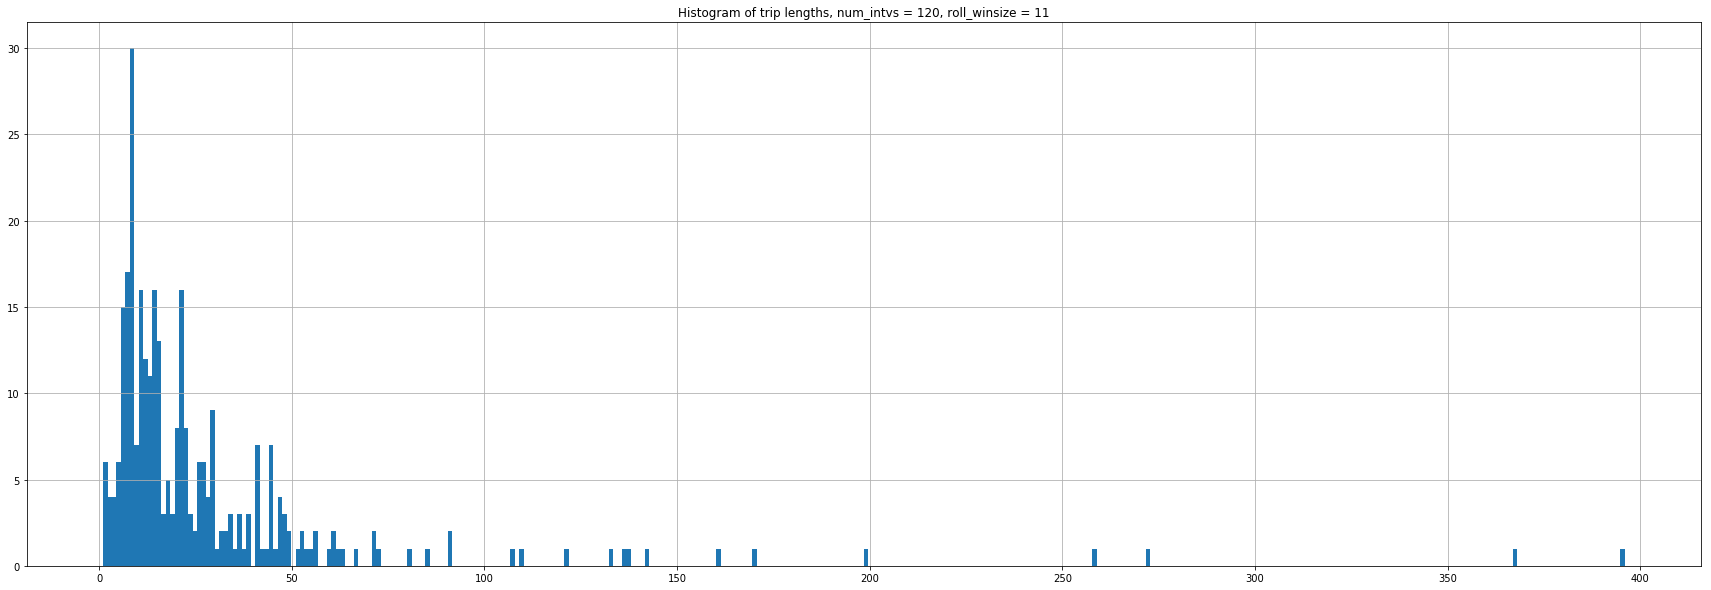

In [227]:
flat_list = [item for sublist in rolled_trip_lenghs for item in sublist]
flat_series = pd.Series(flat_list)

plt.figure(figsize=(30,10))


flat_series_filtered = flat_series[flat_series<20]
flat_series.hist(bins=340)
plt.title('Histogram of trip lengths, num_intvs = '+str(num_intervals_per_hour)+', roll_winsize = '+str(rolling_window_size)+'')

In [228]:
#use diff to identify entries (with 1) and exits (with -1)
#(sum_of_abs / 2) gives us the presumed number of trips a bee takes 
diffed = rolled.diff(axis=1)
diffed.iloc[:,0] = np.zeros([11,1]) #clean out a column of NaNs 
diffed.head()

#a copy to be used to preview rolled + diffed presence 
#not actually used in further calculations (they are just based on 'diffed')
presence_df_copy = presence_df
presence_df_copy.iloc[:, 1:] = diffed 

trips_df = presence_df['id'] #for combining results in one table

In [229]:
presence_df_copy2 = presence_df_copy
presence_df_copy2.iloc[:,0] = bee_days_since_birth
presence_df_copy2.head()

,Unnamed: 0,id,id.1,id.2,id.3,id.4,id.5,id.1.1,id.2.1,id.3.1,...,2879.1,2879.2,2879.3,2879.4,2879.5,2879.5.1,2879.5.2,2879.5.3,2879.5.4,2879.5.5
0,32,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
#for loop config
bin_starttime = datetime_start
num_intervals_per_bin = num_intervals_per_hour*bin_size_in_hours
total_num_bins = int(num_hours / bin_size_in_hours)

print("num_intervals_per_bin: ", num_intervals_per_bin, "total_num_bins: ", total_num_bins)
for bin_nr in range(total_num_bins): 
    
    start_index = bin_nr*num_intervals_per_bin
    end_index = start_index + num_intervals_per_bin
    
    new_bin = diffed.iloc[:, start_index:end_index]
    
    #limit down to the right bin:
    #read num_intervals_per_hour*bin_size_per_hour columns (as each column represents one interval)
    
    summed = new_bin.abs().sum(axis=1) / 2
    summed.name = bin_nr
    trips_df = pd.concat([trips_df,summed],axis=1) #add this interval to the trips table
    #update loop index
    

# TODO:use a new variable instead of reusing it
# Change values to amount per hour instead of per interval
trips_df = trips_df * 3600 / num_intervals_per_hour

num_intervals_per_bin:  2880 total_num_bins:  1


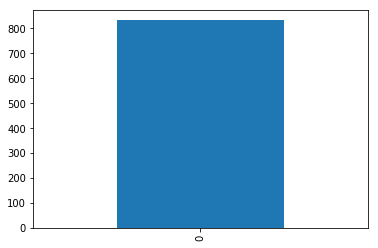

In [231]:
trips_ser = pd.Series(np.array(trips_df.mean(axis=0))[1:])
trips_ser.plot(kind='bar')
# trips_df

In [232]:
#saving (name still incomplete)
date_string = (datetime_start).strftime("%Y-%m-%d_%H:%M:%S")+".csv"
trips_df.to_csv('/mnt/storage/janek/'+'TRIPS-'+date_string+'-'+'h'+'.csv')

In [233]:
#Create dataframe with age and amount of trips
summed_age=pd.concat([pd.Series(bee_days_since_birth),summed],axis=1)
summed_age.columns=['age','amount']
summed_age

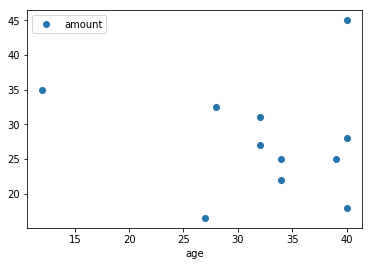

In [235]:
#Plot amount of trips relative to age of bee
summed_age.plot(x='age',y='amount',style='o')